# Spark Clustering

In this section we will create clusters based on the top 150 hotels in the top 40 check-in dates, by Discount Code.

At this point, we will use only PySpark as a Spark usage.

## *** Spark Init ***

First, we will initialize the Spark Context in order to work with it.

In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc

spark = SparkSession.builder \
            .master('local') \
            .appName('hotels') \
            .getOrCreate()
            
sc = spark.sparkContext 

## *** Data Manipulation ***

Now, after Spark Context is initialized, we can start handling the data itself.

First, by reading the data out of the csv file. The file contains all the data about the hotels.
Then, Taking only the top 150 hotels, counted by apperance in the data file.

In [51]:
def mapByHotelName(row):
    key = row['Hotel Name']
    val = 1
    return (key,val)

def reduceByCount(val1, val2):
    return (val1 + val2)

hotels_num = 150

hotels_rdd = spark.read.csv('../input/Hotels_Data_Changed.csv',header=True).rdd
hotel_names_top150 = hotels_rdd \
            .map(mapByHotelName) \
            .reduceByKey(reduceByCount) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: (x[0], x[1])) \
            .take(hotels_num)
            
hotel_names_keys = sc.parallelize(hotel_names_top150).keys().collect()
            
hotels_top = hotels_rdd.filter(lambda x: x['Hotel Name'] in hotel_names_keys)

### *** Top 150 hotels ***

In [54]:
for index,hotel in enumerate(hotel_names_top150):
    print (index+1, hotel[0],hotel[1])

1 Newark Liberty International Airport Marriott 5346
2 Hilton Garden Inn Times Square 4892
3 Residence Inn Newark Elizabeth Liberty International Airport 4314
4 Westin New York at Times Square 3792
5 Loews Regency New York Hotel 3617
6 Viceroy New York 3565
7 Four Seasons Hotel New York 3243
8 Langham Place New York Fifth Avenue 3203
9 The Carlyle A Rosewood Hotel 3078
10 DoubleTree by Hilton Metropolitan - New York City 2866
11 Magnuson Convention Center Hotel 2862
12 Hilton Garden Inn New York West 35th Street 2822
13 Hilton Garden Inn New York-Times Square Central 2772
14 Conrad New York 2677
15 Wyndham Garden Brooklyn Sunset Park 2599
16 Hilton Newark Airport 2524
17 Omni Berkshire Place 2358
18 Hilton Times Square 2273
19 Park Hyatt New York 2226
20 Homewood Suites by Hilton NY Midtown Manhattan Times Square 2211
21 Grand Hyatt New York 2165
22 The Plaza Hotel 2149
23 Quality Inn Woodside 2140
24 Hyatt Union Square New York 2114
25 Le Parker Meridien New York 2109
26 The New York 

## *** Top 40 dates ***

Now we will get the top 40 check-in dates that are found in the top 150 hotels (The top 40 dates, that we found in the list of the top 150 hotels).

In [63]:
def mapByCheckinDate(row):
    key = row['Checkin Date']
    val = 1
    return (key,val)

checkin_date_num = 40

checkin_top = hotels_top \
            .map(mapByCheckinDate) \
            .reduceByKey(reduceByCount) \
            .sortBy(lambda x: x[1], ascending = False) \
            .map(lambda x: (x[0], x[1])) \
            .take(checkin_date_num)

checkin_top_keys = sc.parallelize(checkin_top).keys().collect()
checkin_top_keys.sort()
            
top_hotels_in_date = hotels_top.filter(lambda x: x['Checkin Date'] in checkin_top_keys) \
                        .sortBy(lambda x: x['Discount Code']) \
                        .sortBy(lambda x: x['Hotel Name']) \
                        .sortBy(lambda x: x['Checkin Date'])

### *** Top 40 dates of the top 150 hotels ***

In [59]:
for index,date in enumerate(checkin_top):
    print(index+1,date[0],date[1])

1 2015-08-12 1765
2 2015-08-13 1210
3 2015-08-19 1883
4 2015-08-26 1559
5 2015-08-27 1239
6 2015-08-28 1251
7 2015-09-09 1616
8 2015-09-10 1623
9 2015-09-11 1332
10 2015-09-16 1407
11 2015-09-17 1402
12 2015-09-18 1326
13 2015-09-30 1464
14 2015-10-01 1373
15 2015-10-02 1280
16 2015-10-07 1257
17 2015-10-14 1887
18 2015-10-15 1473
19 2015-10-16 1309
20 2015-10-21 1817
21 2015-10-22 1662
22 2015-10-27 1227
23 2015-10-28 1861
24 2015-10-29 1623
25 2015-10-30 1412
26 2015-11-03 1215
27 2015-11-04 1885
28 2015-11-05 1684
29 2015-11-06 1808
30 2015-11-07 1256
31 2015-11-10 1548
32 2015-11-11 2302
33 2015-11-12 1649
34 2015-11-13 1547
35 2015-11-18 1582
36 2015-11-21 1469
37 2015-11-25 1175
38 2015-11-26 1356
39 2015-11-27 1306
40 2015-11-28 1383


## *** Prepare for cluster ***

Create the matrix with the values that will fill the missing holes.

Based on our data we might have hotels that got no data for spacific check-in dates.

In [71]:
def createAllKeys(hotels,dates,codes):
    names_keys = sc.parallelize(hotels)
    dates_keys = sc.parallelize(dates)
    codes_keys = sc.parallelize(codes)
    return names_keys.cartesian(dates_keys.cartesian(codes_keys)).map(lambda x: (x[0], x[1][0], x[1][1]))

hotels_date_price_missing_data = createAllKeys(hotel_names_keys,checkin_top_keys,['1','2','3','4']).map(lambda x: (x, -1))

## *** Structure the data ***

Now, we build the data in the wanted structure based on the hotels and the dates that selected before

The discount code added to the structure becaues there are 4 different values, and we are going to process the data based on it. 

In [72]:
def mapHotelDatesDiscountCode(row):
    key = (row['Hotel Name'],row['Checkin Date'],row['Discount Code'])
    val = float(row['Discount Price'])
    return (key,val)


hotels_date_price = \
        top_hotels_in_date \
                .map(mapHotelDatesDiscountCode)

## *** Data merge ***

We merge the real data and the "filling" data, taking the minimal values. 

Then grouping by the hotel names, because later on we will process the data and cluster it between different hotels.

In [89]:
def reduceByHotelAndCheckinDate(val1,val2):
    if val1 == -1:
        return val2
    elif val2 == -1:
        return val1
    else:
        return min(val1,val2)
    
hotels_date_price_all_values_before_group = sc.union([hotels_date_price_missing_data, hotels_date_price]).reduceByKey(reduceByHotelAndCheckinDate).sortByKey()
hotels_date_price_all_values = hotels_date_price_all_values_before_group.map(lambda x: (x[0][0], x[1])).groupByKey().sortByKey().mapValues(list)

### *** Prices of hotels in check-in dates for each discount code ***

In [180]:
import pandas as pd

columns = ['Hotel Name'] + [i for i in hotels_date_price_all_values_before_group.map(lambda x: (x[0][1], x[0][2])).distinct().sortBy(lambda x: x[1]).sortByKey().collect()]

pd.set_option('max_colwidth',200)
df = pd.DataFrame(hotels_date_price_all_values.map(lambda x: [x[0]] + x[1]).take(150), columns=columns)
df

,Hotel Name,"(2015-08-12, 1)","(2015-08-12, 2)","(2015-08-12, 3)","(2015-08-12, 4)","(2015-08-13, 1)","(2015-08-13, 2)","(2015-08-13, 3)","(2015-08-13, 4)","(2015-08-19, 1)",...,"(2015-11-26, 3)","(2015-11-26, 4)","(2015-11-27, 1)","(2015-11-27, 2)","(2015-11-27, 3)","(2015-11-27, 4)","(2015-11-28, 1)","(2015-11-28, 2)","(2015-11-28, 3)","(2015-11-28, 4)"
0,Aloft Harlem,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,Andaz 5th Avenue - a concept by Hyatt,-1.0,-1.0,1665.0,-1.0,-1.0,-1.0,-1.0,1339.0,-1.0,...,2181.0,-1.0,-1.0,2778.0,2077.0,2462.0,2884.0,2161.0,2604.0,2944.0
2,Andaz Wall Street - a concept by Hyatt,1365.0,1325.0,1355.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1138.0,1098.0,2066.0,1484.0,1371.0,1785.0,1749.0,1578.0,-1.0,-1.0
3,Baccarat Hotel and Residences New York,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,5225.0,5225.0,4250.0,-1.0,-1.0,-1.0,-1.0
4,Bentley Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1104.0,-1.0
5,Best Western Bayside Inn,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,796.0,-1.0,677.0,736.0,786.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,Best Western Bowery Hanbee Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1026.0,985.0
7,Best Western Plus Arena Hotel,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1006.0,-1.0,-1.0,872.0,677.0,-1.0,-1.0
8,Best Western Plus Newark Airport West,620.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,538.0,556.0,-1.0,-1.0,-1.0,553.0,-1.0,-1.0
9,Blakely New York,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## *** Normalisation ***

After getting the prices of each hotel, in each check-in date for each discount code, we want to normalise the prices (0-100) so it will be much easier to process the data and cluster it based on the prices of each hotel.

The lowest price will be 0 and the highest price will be 100. The normalisation is for each hotel and not by all of the hotels).

Missing prices are still going to be -1 so we will not take it as part of the real prices.

The normalisation process is a regular MinMax normalisation but with some conditions:

1. If the real price is -1 - we will return -1 because it is missing data
2. If the difference between the highest and lowest prices are 0 (all of the prices are the same) then we return 0 (Could be 1 as well)
3. Otherwise - Returning the real normalised price (Between 0 and 1) based on the MinMax normalisation calculation when the range is between 0-100.

In [119]:
def normalise(prices):
    filtered_prices = list(filter(lambda x: x != -1, prices))
    
    if len(filtered_prices) == 0:
        return prices
    
    max_price = max(filtered_prices)
    min_price = min(filtered_prices)
    
    diff = max_price - min_price
    
    arr = []
    for price in prices:
        if price == -1:
            arr.append(price)
        elif diff == 0:
            arr.append(0)
        else:
            arr.append(float(price - min_price) * 100/diff)
            
    return arr

normalised_hotels_prices = hotels_date_price_all_values.map(lambda x: (x[0], normalise(x[1])))
normalised_prices = normalised_hotels_prices.values()

### *** Normalised hotels prices ***

In [184]:
df = pd.DataFrame(normalised_hotels_prices.map(lambda x: [x[0]] + x[1]).take(150), columns=columns)
df

,Hotel Name,"(2015-08-12, 1)","(2015-08-12, 2)","(2015-08-12, 3)","(2015-08-12, 4)","(2015-08-13, 1)","(2015-08-13, 2)","(2015-08-13, 3)","(2015-08-13, 4)","(2015-08-19, 1)",...,"(2015-11-26, 3)","(2015-11-26, 4)","(2015-11-27, 1)","(2015-11-27, 2)","(2015-11-27, 3)","(2015-11-27, 4)","(2015-11-28, 1)","(2015-11-28, 2)","(2015-11-28, 3)","(2015-11-28, 4)"
0,Aloft Harlem,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,Andaz 5th Avenue - a concept by Hyatt,-1.000000,-1.000000,20.311526,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,...,52.461059,-1.000000,-1.000000,89.657321,45.981308,69.968847,96.261682,51.214953,78.816199,100.000000
2,Andaz Wall Street - a concept by Hyatt,22.478386,20.172911,21.902017,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,9.394813,7.089337,62.881844,29.337176,22.824207,46.685879,44.610951,34.755043,-1.000000,-1.000000
3,Baccarat Hotel and Residences New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,85.714286,85.714286,35.064935,-1.000000,-1.000000,-1.000000,-1.000000
4,Bentley Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,11.147851,-1.000000
5,Best Western Bayside Inn,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,70.484581,-1.000000,18.061674,44.052863,66.079295,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,Best Western Bowery Hanbee Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,20.685279,15.482234
7,Best Western Plus Arena Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,49.924127,-1.000000,-1.000000,29.590288,0.000000,-1.000000,-1.000000
8,Best Western Plus Newark Airport West,60.377358,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,8.805031,20.125786,-1.000000,-1.000000,-1.000000,18.238994,-1.000000,-1.000000
9,Blakely New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


## *** Bisecting K-Means ***

Bisecting k-means is an hierarchical clustering algorithm of Spark

Now we are going to train the cluster model of the algorithm based on the normalised data

The algorithm will find the hotels cluster based on the comparison of the hotels' prices. The more the hotels' prices are the same, it means that they should be in the same cluster.

We will run the Bisecting K-Means model based on multiple different k (k is the number of leaves clusters). afterwise, we will explore the data and check the k for which the compute cost is low enough, and the k is low enough so it will be generic and not specific for the train process.

The algorithm starts from a single cluster that contains all points. Iteratively it finds divisible clusters on the bottom level and bisects each of them using k-means, until there are k leaf clusters in total or no leaf clusters are divisible.

The maxIterations parameter set the maximum iterations that we allow the algorithm to run. If (for instance) maxIterations=5, it means that after 5 iterations the algorithm stops, even if we didn't find the desired k leaf clusters (If we already find the k clusters before the end of the maxIterations then it doesn't matter). In this case, we set maxIterations=20 (Which is already the default value).

In [186]:
from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

k=5
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 12100995.178172592


In [188]:
k=20
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 10412841.168789608


In [189]:
k=30
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 9369511.300963003


In [190]:
k=50
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 7941752.286408742


In [191]:
k=70
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 5970147.021334536


In [192]:
k=100
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 3642208.32452546


In [242]:
k=hotels_num
model = BisectingKMeans().train(normalised_prices, k, maxIterations=20)
cost = model.computeCost(normalised_prices)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 0.0


### *** Explaining the k centers ***

After training the Bisecting K-Means hirarchical clustering, we get an insight - As k (number of centers) increase - The summarize of the squared errors decrease.

This is because we increase the total number of clusters - therefore we can define the best cluster for each sample.

If the total number of cluster is as the size of the whole sample array (k=n), it means that the summarize of squared errors is 0, because we can find the best cluster for each sample, which is the sample itself.

It is not a good solution to choose k=n because we are getting a specific clustering training model for the problem - if a new sample is found, then we can't found the best cluster for it.

If we choose k < n but with good cost, then we will find a generic clustering solution and when a new sample will arrive we can find a good cluster for it.


### *** Explaining the cost ***

The Bisecting K-Means cost is the sum of squared distances of points to their nearest center. It means that when the cost is higher - The distance of the samples from their centers is bigger - Which implies that the clusters found aren't as good as we need. If the cost is lower - The distance of the samples from their centers is smaller - Which implies that the clusters found are good and we found good clusters of our data.

The cost will always decrease with larger k, but of course k=n is of no use. At some point, the cost will not decrease much between values (this implies that probably two centers are used in the same grouping of data, so the squared distance to either is similar). Then this is a good place to choose k (Because from now on the cost will not change dramatically).

## *** Using scipy hierarchy cluster ***

Now we are going to train the scipy hierarchy cluster based on the normalised data

The algorithm will find the hotels cluster based on the comparison of the hotels' prices. The more the hotels' prices are the same, it means that they should be in the same cluster.

It's the same goal like the Bisecting K-Means clustring but now we will use different algorithm - ** linkage **

linkage performs hierarchical clustering on the condensed distance matrix

we will check which of the linkage methods have the best result:

In [207]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from matplotlib import pyplot as plt

samples = normalised_prices.take(hotels_num)

ward = linkage(samples, 'ward')
wardc, coph_dists = cophenet(ward, pdist(samples))
complete = linkage(samples, 'complete')
completec, coph_dists = cophenet(complete, pdist(samples))
single = linkage(samples, 'single')
singlec, coph_dists = cophenet(single, pdist(samples))
average = linkage(samples, 'average')
averagec, coph_dists = cophenet(average, pdist(samples))
weighted = linkage(samples, 'weighted')
weightedc, coph_dists = cophenet(weighted, pdist(samples))

print('Ward:' + str(wardc))
print('Complete:' + str(completec))
print('Single:' + str(singlec))
print('Average:' + str(averagec))
print('Weighted:' + str(weightedc))

Ward:0.6313690597146779
Complete:0.798077808945792
Single:0.8386306685599263
Average:0.883316795409844
Weighted:0.8085457332927564


The average distance method, which is decribed by the average of distances between all the features from cluster a to cluster b, gives us the best result (The more closer to 1 - the better). Which means it highly preserves the original distances between the clusters.

Now, we will draw a dendrogram of the average linkage matrix:

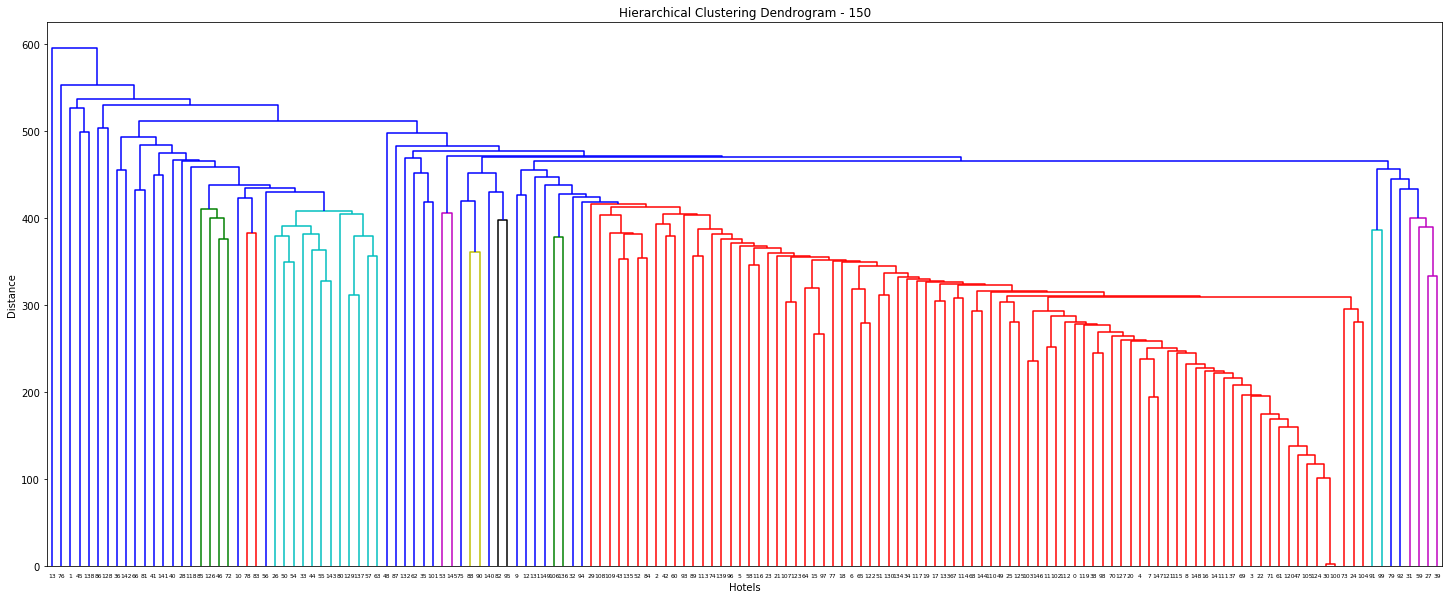

In [237]:
p_merged_clusters = hotels_num

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - {}'.format(p_merged_clusters))
plt.xlabel('Hotels')
plt.ylabel('Distance')

dendrogram(average,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=6.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=p_merged_clusters,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()

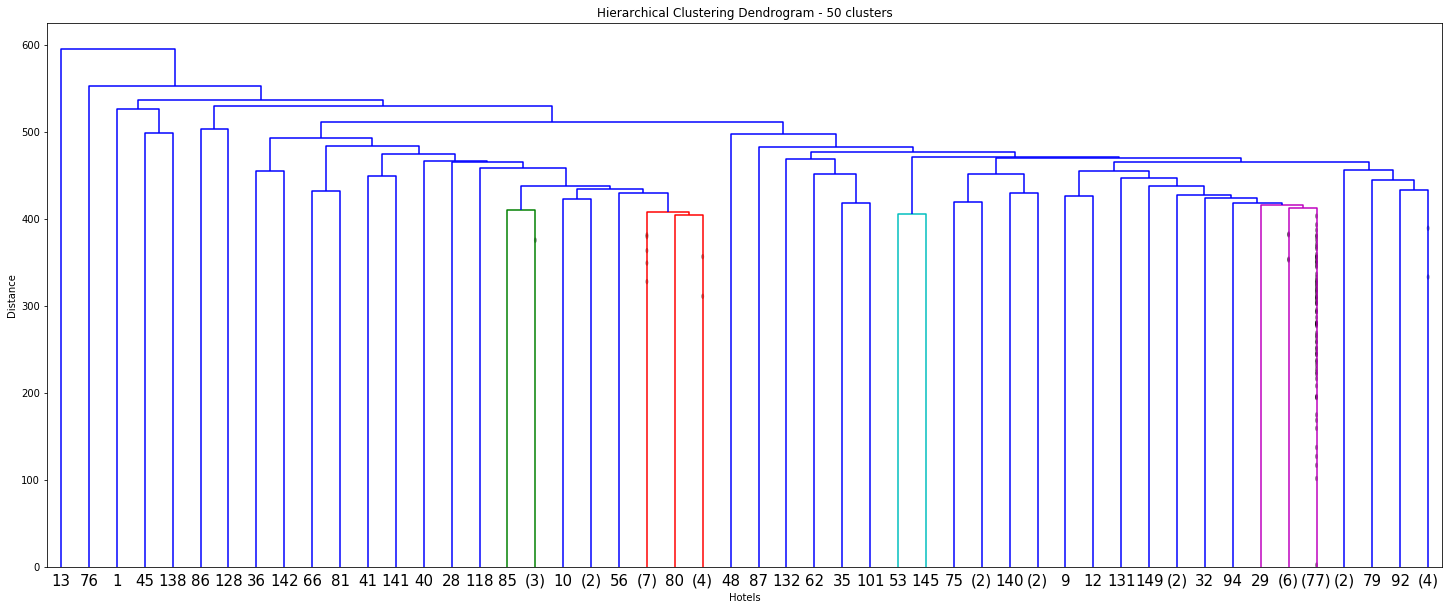

In [241]:
p_merged_clusters = int(hotels_num / 3)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - {} clusters'.format(p_merged_clusters))
plt.xlabel('Hotels')
plt.ylabel('Distance')

dendrogram(average,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=15.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    show_leaf_counts=True,
    p=p_merged_clusters,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()